# Data Download

In [11]:
import pandas as pd
import os
import timeit 
import math
import numpy as np
import gc
import seaborn as sns
import tensorflow as tf
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input
from keras.layers import BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Nadam
from keras.layers import LSTM
from keras.layers import Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.datasets import mnist
from keras.models import load_model
from keras.initializers import RandomNormal
from tqdm import tqdm

In [12]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.42.186.34:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.42.186.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.42.186.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Initializing the Colab TPUs for a better learning process.

## Generative adversarial network

## Data Download

In [22]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Normalize the data using the standard mean for the mnist data
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    x_train = x_train.reshape(x_train.shape[0], 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


In [15]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [16]:
def create_generator():
  generator = Sequential()
  generator.add(Dense(256, input_dim=100, kernel_initializer=RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
  return generator

with tpu_strategy.scope():
  g = create_generator()
g.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 784)              

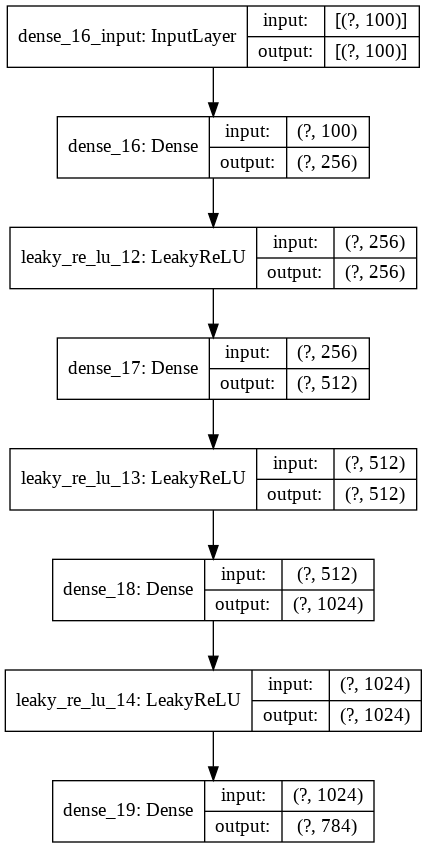

In [17]:
tf.keras.utils.model_to_dot(
    g,
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    subgraph=False,
)
tf.keras.utils.plot_model(g, show_shapes=True)

In [18]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

with tpu_strategy.scope():
  d = create_discriminator()

d.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

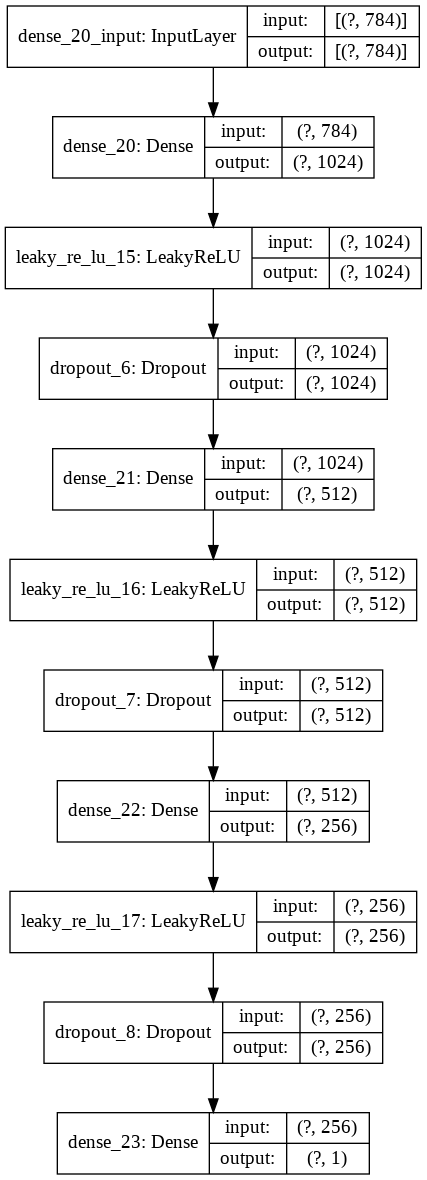

In [19]:
tf.keras.utils.model_to_dot(
    d,
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    subgraph=False,
)
tf.keras.utils.plot_model(d, show_shapes=True)

In [20]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

with tpu_strategy.scope():
  gan = create_gan(d,g)

gan.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [21]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(int(batch_count))):
            noise= np.random.normal(0,1, [batch_size, 100])
            
            image_batch =X_train[np.random.randint(0,X_train.shape[0],size=batch_size)]

            generated_images = generator.predict(noise)

            X= np.concatenate([image_batch, generated_images])
            
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            discriminator.trainable=True
            dloss = discriminator.train_on_batch(X, y_dis)
            
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            discriminator.trainable=False

            gloss = gan.train_on_batch(noise, y_gen)
        dLosses.append(dloss)
        gLosses.append(gloss)
      

tf.debugging.set_log_device_placement(True)

dLosses = []
gLosses = []
training(400,128)

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1


 62%|██████▏   | 291/468 [00:27<00:16, 10.76it/s]

KeyboardInterrupt: ignored

In [ ]:
g.save('/content/drive/My Drive/gan_generator.h5',save_format='h5')
d.save('/content/drive/My Drive/gan_discriminator.h5',save_format='h5')
gan.save('/content/drive/My Drive/gan.h5',save_format='h5')